In [1]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, we filter the data to select columns including winner_age, loser_age, surface, loser_rank, winner_rank, and minutes, and the "surface" column is use to create a new column called "surface_type" by using case_when function. Then the new "surface_type" column is select along the other selected columns. 
Afterthat, we filter out any rows that contain missing values for the selected columns by using the !is.na function.  

In [3]:
tennis_data <- tennis %>%
  select(winner_age, loser_age, surface,loser_rank, winner_rank, minutes) %>%
  mutate(surface_type = case_when(
    surface == "Hard" ~ "Hard",
    surface == "Clay" ~ "Clay",
    surface == "Grass" ~ "Grass",
    TRUE ~ NA_character_
  )) %>%
  mutate(surface_type = as_factor(surface_type)) %>%
  select(surface_type, winner_age, loser_age, loser_rank, winner_rank, minutes) %>%
  filter(!is.na(winner_age) & !is.na(loser_age) & !is.na(surface_type) & 
         !is.na(loser_rank) & !is.na(winner_rank) & !is.na(minutes))

head(tennis_data)

surface_type,winner_age,loser_age,loser_rank,winner_rank,minutes
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hard,29.00479,22.88569,16,9,124
Hard,22.88569,33.70568,239,16,82
Hard,29.00479,31.88227,40,9,66
Hard,33.70568,19.86858,31,239,106
Hard,22.88569,28.01095,18,16,129
Hard,31.88227,26.40383,185,40,127


Then, we first use the initial_split function to separate the data to training and test sets. We specify that prop = 0.75 so that 75% of our original data set ends up in the training set, and the split was stratified based on surface_type, to ensure that the training and testing subsets contain the right proportions of each category of observation. We can see from glimpse in the code that the training set contains 5040 observations, while the test set contains 1682 observations. This corresponds to a train / test split of 75% / 25%, as desired. 

In [4]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = surface_type)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 5,040
Columns: 6
$ surface_type <fct> Clay, Clay, Clay, Clay, Clay, Clay, Clay, Clay, Clay, Cla…
$ winner_age   <dbl> 25.47296, 28.72005, 25.47296, 25.47296, 28.33402, 33.0924…
$ loser_age    <dbl> 28.72005, 33.09240, 28.33402, 23.81656, 21.75222, 35.0417…
$ loser_rank   <dbl> 59, 92, 77, 280, 81, 43, 168, 71, 23, 74, 76, 149, 116, 4…
$ winner_rank  <dbl> 112, 59, 112, 112, 77, 92, 20, 59, 280, 77, 65, 92, 71, 1…
$ minutes      <dbl> 123, 112, 60, 108, 116, 82, 141, 125, 71, 165, 86, 83, 15…
Rows: 1,682
Columns: 6
$ surface_type <fct> Hard, Hard, Hard, Hard, Hard, Hard, Hard, Hard, Hard, Har…
$ winner_age   <dbl> 29.00479, 31.63039, 27.62765, 26.37098, 23.22245, 23.5455…
$ loser_age    <dbl> 22.88569, 26.94319, 23.26078, 21.17454, 31.73717, 29.4620…
$ loser_rank   <dbl> 16, 234, 75, 49, 50, 59, 100, 30, 132, 149, 120, 96, 82, …
$ winner_rank  <dbl> 9, 240, 19, 63, 43, 74, 6, 6, 45, 89, 52, 132, 97, 95, 50…
$ minutes      <dbl> 124, 88, 79, 144, 158, 55, 164, 108, 166, 137, 87, 11

In [5]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(surface_type) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

tennis_proportions

surface_type,n,percent
<fct>,<int>,<dbl>
Hard,2900,57.53968
Clay,1537,30.49603
Grass,603,11.96429


In [6]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(surface_type ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = surface_type)

In [8]:
set.seed(999) 

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4557531,5,0.006052361,Preprocessor1_Model01
3,accuracy,multiclass,0.4885021,5,0.007130166,Preprocessor1_Model02
4,accuracy,multiclass,0.4994122,5,0.005009073,Preprocessor1_Model03
6,accuracy,multiclass,0.5107200,5,0.004001829,Preprocessor1_Model04
7,accuracy,multiclass,0.5212367,5,0.004070905,Preprocessor1_Model05
8,accuracy,multiclass,0.5259984,5,0.004377584,Preprocessor1_Model06
10,accuracy,multiclass,0.5440547,5,0.004774066,Preprocessor1_Model07
12,accuracy,multiclass,0.5494107,5,0.006156587,Preprocessor1_Model08
13,accuracy,multiclass,0.5482161,5,0.003865971,Preprocessor1_Model09


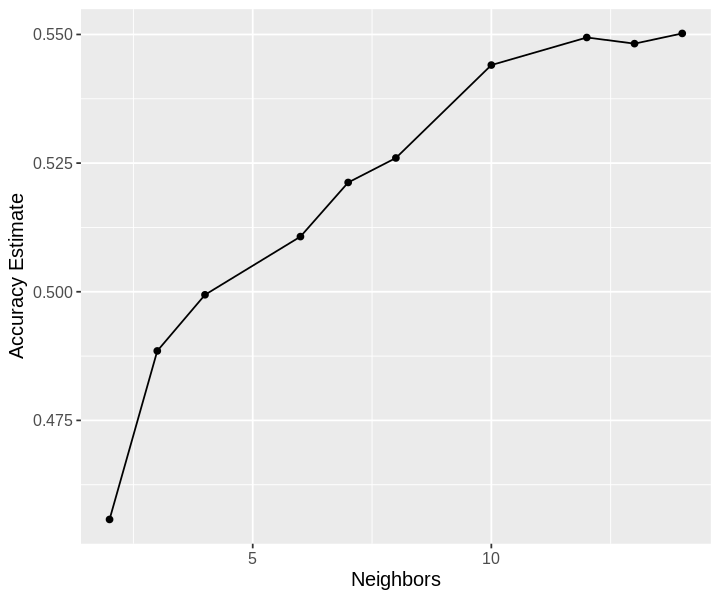

In [9]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(18,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4418651
Best kernel: rectangular
Best k: 18

In [14]:
set.seed(9999) 

# your code here
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
tennis_metrics <- tennis_predictions |>
         metrics(truth = surface_type, estimate = .pred_class) |>
  filter(.metric == "accuracy")
tennis_mat <- tennis_predictions |>
         conf_mat(truth = surface_type, estimate = .pred_class)
head(tennis_predictions)
tennis_metrics
tennis_mat

.pred_class,surface_type,winner_age,loser_age,loser_rank,winner_rank,minutes
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hard,Hard,29.00479,22.88569,16,9,124
Hard,Hard,31.63039,26.94319,234,240,88
Hard,Hard,27.62765,23.26078,75,19,79
Hard,Hard,26.37098,21.17454,49,63,144
Hard,Hard,23.22245,31.73717,50,43,158
Hard,Hard,23.54552,29.46201,59,74,55


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5558859


          Truth
Prediction Hard Clay Grass
     Hard   851  426   182
     Clay   113   84    20
     Grass    3    3     0

The mean and standard deviation of winner_age, loser_age, winner_rank, loser_rank, and minutes were calculated for each surface_type using the summarize function. 

In [ ]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(surface_type) %>%
  summarize(
    avg_winner_age = mean(winner_age),
    avg_loser_age = mean(loser_age),
    avg_winner_rank = mean(winner_rank),
    avg_loser_rank = mean(loser_rank),
    avg_minutes = mean(minutes)
  )

tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(surface_type) %>%
  summarize(
    sd_winner_age = sd(winner_age),
    sd_loser_age = sd(loser_age),
    sd_winner_rank = sd(winner_rank),
    sd_loser_rank = sd(loser_rank),
    sd_minutes = sd(minutes)
  )

tennis_summary_sd

A scatter plot was created using the ggplot function. The plot shows the corralation between loser_age and loser_rank on the x and y axes, respectively, and between winner_age and winner_rank using different colors for each group. 

In [ ]:
set.seed(999)
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(tennis_train) +
  geom_point(aes(x = loser_age, y = loser_rank, color = "Loser")) +
  geom_point(aes(x = winner_age, y = winner_rank, color = "Winner")) +
  scale_color_manual(values = c("Loser" = "blue", "Winner" = "red")) +
  xlab("Age") +
  ylab("Rank") +
  theme_bw() +
  theme( text = element_text(size = 20))


Line plots were created for each surface_type using ggplot function. Each plot shows the distribution of minutes by winner_age for each surface type. 

In [ ]:
set.seed(999)
# hard surface
hard_plot <- ggplot(data = filter(tennis_train, surface_type == "Hard"),
                    aes(x = winner_age, y = minutes)) +
  geom_line() +
  labs(title = "Hard Surface",
       x = "Winner Age",
       y = "Minutes")

# clay surface
clay_plot <- ggplot(data = filter(tennis_train, surface_type == "Clay"),
                    aes(x = winner_age, y = minutes)) +
  geom_line() +
  labs(title = "Clay Surface",
       x = "Winner Age",
       y = "Minutes")

# grass surface
grass_plot <- ggplot(data = filter(tennis_train, surface_type == "Grass"),
                     aes(x = winner_age, y = minutes)) +
  geom_line() +
  labs(title = "Grass Surface",
       x = "Winner Age",
       y = "Minutes")

hard_plot
clay_plot
grass_plot

A box plot was created using ggplot function to compare the distribution of minutes across surface_type. The plot shows the median, quartiles, and outliers of the minutes distribution for each surface_type.

In [ ]:
set.seed(999)
minutes_plot <- ggplot(tennis_train, aes(x = surface_type, y = minutes)) +
  geom_boxplot() +
  xlab("Surface Type") +
  ylab("Minutes") +
  theme_bw() +
  theme(text = element_text(size = 20))

minutes_plot